In [1]:
import numpy as np
import fst
import matplotlib.pyplot as P
%matplotlib inline

# Intro to HMMs

Hidden Markov Models (HMMs) are a well known mathematical construct for modeling sequences of events using probabilistic reasoning. Its advantage is that it's very intuitive and not too hard to implement. You can probably find much more information on places like [Wikipedia](https://en.wikipedia.org/wiki/Hidden_Markov_model) and dozens of other sites you can google (e.g. [this](http://www.comp.leeds.ac.uk/roger/HiddenMarkovModels/html_dev/main.html) one is one of my favorites).

For speech recognition, the go to paper is an old one by [Rabiner](http://www.ee.columbia.edu/~dpwe/e6820/papers/Rabiner89-hmm.pdf) which is written in a very simple and easy to understand way with examples specifically tuned to its application in speech recognition. If this is your first time hearing about it, you have to go and read that paper at once. This notebook will simply go through some of the major points written there and show their implementation in Python.

## HMM algorithms

The Rabiner paper mentions 3 problems that are solved using HMMs:

  1. Find the joint probability of a sequence of states given an HMM model - solved using the Forward algorithm
  2. Finding the most likely sequence of hidden states given the probability above - solved using the Viterbi algorithm
  3. Fine-tuning the parameters of the model by observing the likelihood of each state transition at each point in time - the Baum-Welch algorithm based around the Forward-Backward mechanic
  
As a reminder, the HMM is defined by the following parameters:

  * observation probability - classically is the output of a Gaussian Mixture Model (GMM), but we want to use the output of the ANN (e.g. MLP) here instead. For consistency with the Rabiner paper we will instead use a discrete model here, which means that observations will simply be some descreete events and the model will gives us a simple value of how probable this event is given a particular state (from a lookup table) 
  * hidden states - in our case, these are the units we try to recognize: e.g. phonemes, but also possibly things like words, which are a combination of phonemes (models can be combined in several layers - more on that later)
  * transitions - as the name suggests, transitions from one state to another - these can contain weights that modify the probability (i.e. it is more likely to transition between certain phonemes than others)
  * priors - initial probailities of starting a sequence in a certain state (this is often skipped whithout much problems)
  
To keep things readable, we will use the same notation as in Rabiner's paper:
  * for observations we will use the letter *b*
  * for transitions the letter *a*
  * for priors the word *pi*
  
## Example model

Here we will generate some random values to demonstrate the algorithms. Our HMM wil have 3 states and we will feed 5 observations into it. Each observation is a descrete event of on of 4 possible values. The model will also connect all the states to all the others. We are allowed to start and finish at any state.

#### Constants

These are the constants from above using notation from the Rabiner paper:

In [2]:
N=3
M=4
T=5

#### Observation sequence

We will generate a random sequence of observations:

In [3]:
O=np.random.randint(0,M,T)
print O

[0 1 2 1 0]


The observation matrix will convert these events into probablities for individual states. The matrix is a 3x4 matrix, where the first dimension is the state and second is the observation id:

In [4]:
b=np.random.random((N,M))
b/=np.array([b.sum(axis=0)])
print b

[[ 0.53375578  0.10345127  0.33152859  0.66017725]
 [ 0.26331038  0.65987904  0.40656356  0.11079022]
 [ 0.20293384  0.23666969  0.26190785  0.22903253]]


Note that probabilites for individual events have to sum to 1, i.e. each event is modeled by a probability distribution over the states (not the other way around):

In [5]:
print b.sum(axis=0)

[ 1.  1.  1.  1.]


Given thes probabilities, we can easily estimate the observation probabilities in time:

In [6]:
ob=np.zeros((T,N))
for t in range(T):
    for i in range(N):
        ob[t,i]=b[i,O[t]]
print ob

[[ 0.53375578  0.26331038  0.20293384]
 [ 0.10345127  0.65987904  0.23666969]
 [ 0.33152859  0.40656356  0.26190785]
 [ 0.10345127  0.65987904  0.23666969]
 [ 0.53375578  0.26331038  0.20293384]]


Or in simpler, Numpy terms:

In [7]:
ob=b.T[O]
print ob

[[ 0.53375578  0.26331038  0.20293384]
 [ 0.10345127  0.65987904  0.23666969]
 [ 0.33152859  0.40656356  0.26190785]
 [ 0.10345127  0.65987904  0.23666969]
 [ 0.53375578  0.26331038  0.20293384]]


These also sum to 1 at each time step:

In [8]:
print ob.sum(axis=1)

[ 1.  1.  1.  1.  1.]


Please note that in our case, we will reaplace this lookup table with a proper model, e.g. an MLP or something better. This simple model will let us demonstrate the Baum-Welch algorithm, which is normally not used when talking about hybrid ANN-HMM models.

#### State transition matrix

The state transition matrix is 3x3 and its rows also have to sum to 1 (i.e. the sum of probabilities of going from one state to all the others has to be equal one):

In [9]:
a=np.random.random((N,N))
a/=np.array([a.sum(axis=-1)]).T
print a
print a.sum(axis=1)

[[ 0.44056368  0.08175695  0.47767937]
 [ 0.4364632   0.40292622  0.16061058]
 [ 0.00281623  0.88340507  0.1137787 ]]
[ 1.  1.  1.]


#### Priors

We will also generate the priors. You can use random values or set everything to equally likely. The code below should work either way:

In [10]:
pi=np.random.random(N)
pi/=pi.sum()
print pi

[ 0.13060479  0.574861    0.29453421]


#### Final model

To make things easier to read below, we will merge all the values above into a single tuple:

In [11]:
hmm=(O,pi,a,b,N,M,T)

Here is some short code to save the model to a file:

In [12]:
import pickle

with open('../data/hmm.pkl','w') as f:
    pickle.dump(hmm,f,pickle.HIGHEST_PROTOCOL)

### Forward algorithm

Implementing the algorithm directly using Rabiner's paper would look like this. Note that Rabiner iterates his vectors/matrices starting from 1 (which is a standard in mathematics), but Python (as most computer programming languages) iterates from 0, so there is a little offset everywhere:

In [13]:
def forward(O,pi,a,b,N,M,T):
    fwd=np.zeros((T,N))

    #initiazliation
    for i in range(N):
        fwd[0,i]=pi[i]*b[i,O[0]]

    #induction
    for t in range(T-1):
        for j in range(N):
            s=0
            for i in range(N):
                s+=fwd[t,i]*a[i,j]
            fwd[t+1,j]=s*b[j,O[t+1]]
            
    return fwd

print forward(*hmm)

[[ 0.06971106  0.15136687  0.05977096]
 [ 0.01002924  0.07884961  0.01524421]
 [ 0.01288864  0.01872524  0.00502583]
 [ 0.00143438  0.00860381  0.0023042 ]
 [ 0.00234515  0.00147968  0.00047268]]


Numpy allows us to implement this a bit more efficiently:

In [14]:
def forward(O,pi,a,b,N,M,T):
    fwd=np.zeros((T,N))

    #initialization
    fwd[0]=pi*b[:,O[0]]

    #induction:
    for t in range(T-1):
        fwd[t+1]=np.dot(fwd[t],a)*b[:,O[t+1]]
    
    return fwd

print forward(*hmm)

[[ 0.06971106  0.15136687  0.05977096]
 [ 0.01002924  0.07884961  0.01524421]
 [ 0.01288864  0.01872524  0.00502583]
 [ 0.00143438  0.00860381  0.0023042 ]
 [ 0.00234515  0.00147968  0.00047268]]


In [15]:
def forward(O,pi,a,b,N,M,T):
    fwd=np.zeros((T,N))

    #initialization
    fwd[0]=pi*b[:,O[0]]
    
    #induction:
    for t in range(T-1):
        fwd[t+1]=np.dot(fwd[t],a)*b[:,O[t+1]]
    
    return fwd

print forward(*hmm)

[[ 0.06971106  0.15136687  0.05977096]
 [ 0.01002924  0.07884961  0.01524421]
 [ 0.01288864  0.01872524  0.00502583]
 [ 0.00143438  0.00860381  0.0023042 ]
 [ 0.00234515  0.00147968  0.00047268]]


This allows us to determine the joint probability of the sequence given the model (simply a sum of all the forward probabilities at the last time step):

In [16]:
def full_prob(fwd):
    return fwd[-1].sum()

print full_prob(forward(*hmm))

0.00429750109789


### Viterbi algorithm

Note that usually when we classifiy using MLPs directly (without HMMs), we just pick the most probable class at each timestep. This gives us the following sequnce:

In [17]:
np.argmax(ob,axis=1)

array([0, 1, 1, 1, 0])

The sequence above doesn't take any context into account, however. The HMM model tells us that it may be more likely to choose certrain transitions than others. The Viterbi algorithm lets us find the most likely sequence of states (classes), while taking the parameters of the HMM into account:

In [18]:
def viterbi(O,pi,a,b,N,M,T):
    d=np.zeros((T,N))
    ph=np.zeros((T,N),dtype=np.int)

    #initialization
    for i in range(N):
        d[0,i]=pi[i]*b[i,O[0]]
        ph[0,i]=0

    #recursion
    for t in range(1,T):
        for j in range(N):
            m=np.zeros(N)
            for i in range(N):
                m[i]=d[t-1,i]*a[i,j]
            ph[t,j]=m.argmax()
            d[t,j]=m.max()*b[j,O[t]]

    #termination
    m=np.zeros(N)
    for i in range(N):
        m[i]=d[T-1,i]
    Pv=m.max()

    #path back-tracking
    Q=np.zeros(T,dtype=np.int)
    Q[T-1]=m.argmax()
    for t in reversed(range(T-1)):
        Q[t]=ph[t+1,Q[t+1]]
        
    return Q

print viterbi(*hmm)

[1 1 1 1 0]


And a slightly faster Numpy implementation:

In [19]:
def viterbi(O,pi,a,b,N,M,T):
    d=np.zeros((T,N))
    ph=np.zeros((T,N),dtype=np.int)

    #initialization
    d[0]=pi*b[:,O[0]]
    ph[0]=0

    #recursion
    for t in range(1,T):
        m=d[t-1]*a.T        
        ph[t]=m.argmax(axis=1)
        d[t]=m[np.arange(N),ph[t]]*b[:,O[t]]    

    #termination
    Q=np.zeros(T,dtype=np.int)
    Q[T-1]=np.argmax(d[T-1])
    Pv=d[T-1,Q[T-1]]

    #path back-tracking
    for t in reversed(range(T-1)):
        Q[t]=ph[t+1,Q[t+1]]

    return Q

print viterbi(*hmm)

[1 1 1 1 0]


It should also be clear that if we set both the priors and transitions to be equiprobable (all the same value) the best observation and Viterbi paths will be the same.

### Forward-backward routine

The forward algorithm is already implemented above, so here, we will show the backward here:

In [20]:
def backward(O,pi,a,b,N,M,T):
    bk=np.zeros((T,N))
    #initialization
    for i in range(N):
        bk[T-1,i]=1
    #induction:
    for t in reversed(range(T-1)):
        for i in range(N):
            s=0
            for j in range(N):
                s+=a[i,j]*b[j,O[t+1]]*bk[t+1,j]            
            bk[t,i]=s
    return bk

print backward(*hmm)

[[ 0.00983429  0.01427416  0.02428114]
 [ 0.04165409  0.03925479  0.05146331]
 [ 0.06524467  0.12455948  0.22368039]
 [ 0.35361817  0.37165273  0.25720245]
 [ 1.          1.          1.        ]]


And in Numpy:

In [21]:
def backward(O,pi,a,b,N,M,T):
    bk=np.zeros((T,N))
    #initialization:
    bk[T-1]=1
    #induction:
    for t in reversed(range(T-1)):
        bk[t]=np.dot(bk[t+1]*b[:,O[t+1]],a.T)
    return bk

print backward(*hmm)

[[ 0.00983429  0.01427416  0.02428114]
 [ 0.04165409  0.03925479  0.05146331]
 [ 0.06524467  0.12455948  0.22368039]
 [ 0.35361817  0.37165273  0.25720245]
 [ 1.          1.          1.        ]]


When we have both Forward and Backward probabilities computed, we can use them together to estimate the probability of each state, at each point in time, by simply multuplying those two probablilities together. This works, because is the probability of a sequence from time 0 to time $t$ and backward is the probabilty from time $t$ to the end $T$. Adding them together gives a complete probability of passing that state in time. Addtionally, we normalize this by the joint probability $P$ to make sure everything sums up nicely (i.e. each timestep sums to 1):

In [22]:
def gamma(fwd,bk,fp):
    gm=np.zeros((T,N))
    for t in range(T):
        for i in range(N):
            gm[t,i]=(fwd[t,i]*bk[t,i])/fp
    return gm

print gamma(forward(*hmm),backward(*hmm),full_prob(forward(*hmm)))

[[ 0.15952497  0.50276549  0.33770954]
 [ 0.09720975  0.72023827  0.18255198]
 [ 0.19567537  0.54273542  0.26158921]
 [ 0.11802761  0.74406748  0.13790491]
 [ 0.5457006   0.34431105  0.10998835]]


Numpy one-liner:

In [23]:
def gamma(fwd,bk,fp):
    return (fwd*bk)/fp

print gamma(forward(*hmm),backward(*hmm),full_prob(forward(*hmm)))

[[ 0.15952497  0.50276549  0.33770954]
 [ 0.09720975  0.72023827  0.18255198]
 [ 0.19567537  0.54273542  0.26158921]
 [ 0.11802761  0.74406748  0.13790491]
 [ 0.5457006   0.34431105  0.10998835]]


We can compare the three probailities using a plot. You can notice on the plot (and it should be obvious from the equations) that forward probabilities decay exponentially in time and similarly (but in the opposite direction) with the backward probabilities. Adding them together, evens everything out and the full path denotes clearly what the most likely state at each step is.

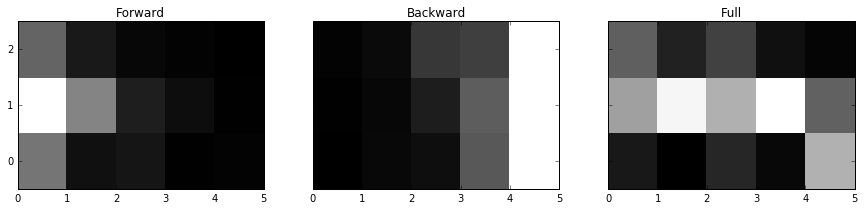

In [24]:
fig,ax=P.subplots(1,3,figsize=(15,3),sharey=True)


ax[0].pcolormesh(forward(*hmm).T,cmap=P.cm.gray)
ax[0].set_yticks(np.arange(0,N)+.5)
ax[0].set_yticklabels(np.arange(0,N))
ax[0].set_title('Forward')

ax[1].pcolormesh(backward(*hmm).T,cmap=P.cm.gray)
ax[1].set_title('Backward')

g=gamma(forward(*hmm),backward(*hmm),full_prob(forward(*hmm)))
ax[2].pcolormesh(g.T,cmap=P.cm.gray)
ax[2].set_title('Full')


Please note there are many sequences we can extract now and they are all different and NOT equivalent in any way, so you cannot use them interchangebly.

  * we can get the best observation at each timestep, which doesn't take the transitions or priors of the HMM into account
  * we can take the best forward or backward probability at each time step, which takes only the history/future into account
  * we can take the best full-probability at each time step, but this isn't actually the most likely *sequence* - it is just the most likely state, i.e. there are many possible sequences and that is the *average* probability of all the sequences (likely or not) that go through that state
  * finally, we can get simply the most likely sequence using the Viterbi algorithm
  
The problem with full probability argmax not being equivalent to the Viterbi sequence can also be explained by the fact that the two states in the full prob. sequence don't have to even be a part of the same sequence.

In [25]:
print 'Best observation sequence: {}'.format(np.argmax(ob,axis=1))
print 'Best forward prob. sequence: {}'.format(np.argmax(forward(*hmm),axis=1))
print 'Best backward prob. sequence: {}'.format(np.argmax(backward(*hmm),axis=1))
g=gamma(forward(*hmm),backward(*hmm),full_prob(forward(*hmm)))
print 'Best full prob. sequence: {}'.format(np.argmax(g,axis=1))
print 'Best Viterbi sequence: {}'.format(viterbi(*hmm))

Best observation sequence: [0 1 1 1 0]
Best forward prob. sequence: [1 1 1 1 0]
Best backward prob. sequence: [2 2 2 1 0]
Best full prob. sequence: [1 1 1 1 0]
Best Viterbi sequence: [1 1 1 1 0]


### Baum-Welch

Now we can also determine the sequence probablity, which would help us with fine-tuning the state transition likelihood. You can read about the Baum-Welch algorithm in Rabiner's paper, but this is something that is not really used much in hybrid ANN-HMM models. We are mentioning it here more for sake of curiousity:

The transition probability computed for each timestep gives us a 3D matrix of size 4x3x3, since there are $N^2$ transitions at each timestep and only $T-1$ transitions time steps (i.e. number of transitions between 5 consecutive timesteps). The matrix is computed thusly:

In [26]:
def xi(fwd,bk,fp,O,pi,a,b,N,M,T):
    ret=np.zeros((T-1,N,N))
    for t in range(T-1):
        for i in range(N):
            for j in range(N):
                ret[t,i,j]=(fwd[t,i]*a[i,j]*b[j,O[t+1]]*bk[t+1,j])/fp                
    return ret

print xi(forward(*hmm),backward(*hmm),full_prob(forward(*hmm)),*hmm)

[[[  3.07955404e-02   3.43532117e-02   9.43762150e-02]
  [  6.62454248e-02   3.67618460e-01   6.89016034e-02]
  [  1.68785883e-04   3.18266595e-01   1.92741635e-02]]

 [[  2.22395996e-02   9.66233633e-03   6.53078151e-02]
  [  1.73219688e-01   3.74381469e-01   1.72637109e-01]
  [  2.16084372e-04   1.58691610e-01   2.36442879e-02]]

 [[  4.83359429e-02   6.01336344e-02   8.72057951e-02]
  [  6.95711863e-02   4.30564850e-01   4.25993795e-02]
  [  1.20484393e-04   2.53368996e-01   8.09973173e-03]]

 [[  7.84874698e-02   7.18524727e-03   3.23548965e-02]
  [  4.66407165e-01   2.12406845e-01   6.52534701e-02]
  [  8.05964047e-04   1.24718959e-01   1.23799829e-02]]]


Numpy version:

In [27]:
def xi(fwd,bk,fp,O,pi,a,b,N,M,T):
    return fwd[:-1].reshape((T-1,N,1))*a.reshape((1,N,N))*b[:,O[1:]].T.reshape((T-1,1,N))*bk[1:].reshape((T-1,1,N))/fp

print xi(forward(*hmm),backward(*hmm),full_prob(forward(*hmm)),*hmm)

[[[  3.07955404e-02   3.43532117e-02   9.43762150e-02]
  [  6.62454248e-02   3.67618460e-01   6.89016034e-02]
  [  1.68785883e-04   3.18266595e-01   1.92741635e-02]]

 [[  2.22395996e-02   9.66233633e-03   6.53078151e-02]
  [  1.73219688e-01   3.74381469e-01   1.72637109e-01]
  [  2.16084372e-04   1.58691610e-01   2.36442879e-02]]

 [[  4.83359429e-02   6.01336344e-02   8.72057951e-02]
  [  6.95711863e-02   4.30564850e-01   4.25993795e-02]
  [  1.20484393e-04   2.53368996e-01   8.09973173e-03]]

 [[  7.84874698e-02   7.18524727e-03   3.23548965e-02]
  [  4.66407165e-01   2.12406845e-01   6.52534701e-02]
  [  8.05964047e-04   1.24718959e-01   1.23799829e-02]]]


The expected prior value can be estimated by simply looking at the expected value $\gamma$ at the first point in time:

In [28]:
def exp_pi(gamma):
    return gamma[0]

print exp_pi(gamma(forward(*hmm),backward(*hmm),full_prob(forward(*hmm))))

[ 0.15952497  0.50276549  0.33770954]


The expected transistions is the sum (for different timestep) of transition probabilities $\xi$ normalized by the corresponding emitting state probabilities $\gamma$:

In [29]:
def exp_a(gamma,xi,N):
    e_a=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            e_a[i,j]=np.sum(xi[:,i,j])/np.sum(gamma[:-1,i])
            
    return e_a

fw=forward(*hmm)
bk=backward(*hmm)
fp=full_prob(fw)
g=gamma(fw,bk,fp)
x=xi(fw,bk,fp,*hmm)

ea=exp_a(g,x,N)

print exp_a(g,x,N)

[[ 0.3152992   0.19517369  0.48952711]
 [ 0.30896542  0.55182403  0.13921055]
 [ 0.00142573  0.92964492  0.06892936]]


Numpy version:

In [30]:
def exp_a(gamma,xi,N):            
    return xi[:].sum(axis=0)/gamma[:-1].sum(axis=0).reshape(N,1)

fw=forward(*hmm)
bk=backward(*hmm)
fp=full_prob(fw)
g=gamma(fw,bk,fp)
x=xi(fw,bk,fp,*hmm)

print exp_a(g,x,N)

[[ 0.3152992   0.19517369  0.48952711]
 [ 0.30896542  0.55182403  0.13921055]
 [ 0.00142573  0.92964492  0.06892936]]


Finally, the expected observation likelihood is sum of probabilities of given states at times where the specific observation occured normalized by the sum of all the probilities in time for the given state:

In [31]:
def exp_b(gamma,O,N,M):
    e_b=np.zeros((N,M))
    for j in range(N):
        for k in range(M):        
            e_b[j,k]=np.sum(gamma[O==k,j])/np.sum(gamma[:,j])
    return e_b

fw=forward(*hmm)
bk=backward(*hmm)
fp=full_prob(fw)
g=gamma(fw,bk,fp)

print exp_b(g,O,N,M)

[[ 0.63184425  0.19284112  0.17531463  0.        ]
 [ 0.29679103  0.51305023  0.19015874  0.        ]
 [ 0.43476621  0.31120054  0.25403325  0.        ]]


Numpy version (couldn't figure out how to get rid of the *k* loop):

In [32]:
def exp_b(gamma,O,N,M):    
    return np.array(map(lambda k: np.sum(gamma[O==k],axis=0)/np.sum(gamma,axis=0), np.arange(M))).T

fw=forward(*hmm)
bk=backward(*hmm)
fp=full_prob(fw)
g=gamma(fw,bk,fp)

print exp_b(g,O,N,M)

[[ 0.63184425  0.19284112  0.17531463  0.        ]
 [ 0.29679103  0.51305023  0.19015874  0.        ]
 [ 0.43476621  0.31120054  0.25403325  0.        ]]


#### Updates

The Baum-Welch algorithm now works by repeadatly updating the model parameters in this two step *EM* (first Expectation, then Modification) procedure. The goal of the algorithm is to maximize the $P(O|\Lambda)$, where $O$ is the observation sequence and $\Lambda$ is the model. We will also print out the mean square of the difference of model parameters vs their expected value:

In [49]:
print 'Initial probability: {}'.format(full_prob(forward(*hmm)))

hmm_new=hmm
for i in range(15):
    fw=forward(*hmm_new)
    bk=backward(*hmm_new)
    fp=full_prob(fw)
    g=gamma(fw,bk,fp)
    x=xi(fw,bk,fp,*hmm_new)

    pi_new=exp_pi(g)
    a_new=exp_a(g,x,N)
    b_new=exp_b(g,O,N,M)
    
    err=np.concatenate(((pi_new-hmm_new[1]).ravel(),(a_new-hmm_new[2]).ravel(),(b_new-hmm_new[3]).ravel()))    
    
    hmm_new=(O,pi_new,a_new,b_new,N,M,T)

    print 'Update #{} probability: {} -- mean error: {}'.format(i+1,full_prob(forward(*hmm_new)),np.mean(err**2))

Initial probability: 0.00429750109789
Update #1 probability: 0.00509988830851 -- mean error: 0.0312950732496
Update #2 probability: 0.00619259912726 -- mean error: 0.00250484514145
Update #3 probability: 0.00862175382808 -- mean error: 0.00354749899731
Update #4 probability: 0.0136389139542 -- mean error: 0.00476954018424
Update #5 probability: 0.0189215113683 -- mean error: 0.00249158166715
Update #6 probability: 0.0234132960784 -- mean error: 0.00156689403255
Update #7 probability: 0.037457169758 -- mean error: 0.00485260629198
Update #8 probability: 0.109155856481 -- mean error: 0.00896292597035
Update #9 probability: 0.21859410717 -- mean error: 0.00389884346838
Update #10 probability: 0.238835338999 -- mean error: 0.000297478434192
Update #11 probability: 0.244890426118 -- mean error: 7.89287339611e-05
Update #12 probability: 0.247751721958 -- mean error: 1.83136278322e-05
Update #13 probability: 0.249030029832 -- mean error: 3.72290018409e-06
Update #14 probability: 0.24958516681

Now, this doesn't do anything for optimizing the Viterbi sequence recognized by the model, but there is another way HMMs are trained for speech recognition. Usually, each phonetical unit is modelled by a simple 3-5 state left-to-right model. When we present the recognizer a sentence, we actually combine all these phonetic models into one long chain. Then we try to maximize the $P(O|\Lambda_{\rho})$ for each phoneme (indexed by $\rho$) individually, using the above E-M reestimation procedure.

With hybird ANN-HMM systems, we generally don't use EM training. ANNs are usually trained discriminatevly. In that case, we need a frame-wise alignment to train the model. We can either iteratively re-align the data (using Viterbi) and train the system, or we can use some other cost function (e.g. CTC), skipping the HMM part entirely.

## HMM topologies for speech recognition

To actually perform speech recognition using HMMs, we need to expand the definition of the model considerably. First of all, this model will allow us only to recognize a simple sequence of events. 

Say we create an "acoustic model" (instead of the observation martix) that will recognize phonemes based on some acoustic observations (e.g. STFT filterbank outputs through time). We can easily do this using a simple MLP. Such a model can use HMMs to cconvert the raw MLP outputs into a sequence of phonemes. If we wish to recognize words, we need to create another model to convert that sequence of phonemes into their word representation.

Since a sequence of words is the same kind of sequence as the sequence of phonemes (albeit a bit more sparse), we can model it simply as another layer of HMMs on top of the phoneme one. This layer will not allow any sequence of phonemes, but only the ones that form actual words from a lexicon. We can also add one more layer that will define how words can interact with eachother in a sentence - the so-called language model.

All these layers can get very tricky. In practice, we may decide to acutally recreate this layered model in a single-layered complex graph containg all the weights and contraints of both the phonetic, lexical and language layers together. This is named, by some reaserchers, an "Integrated Network" or IN for short. This turns out to be not enough in order to fully realize our solution, as the hidden states are still phonemes and not words. We can therefore add special non-emitting states (states that don't move the time-line) to denote word bnoundaries - times where a word has to be output.

A slightly more efficient solution would be to instead add an additional field to each state, apart from the phoneme that we are trying to consume, a word that we are trying to output. For most states, this auxilary value would be blank, but every once in a while we would have a word that needs to be output.

Thus we have successfully redefined our classical HMM solution that relied on Finite-State Automata (FSA) to a much more convinient solution that relies of Finite-State Transducers (FST).

# WFST

Weighted Finite State Transducers are a type of automaton that has a sequence of states with transitions between them, just like an HMM. Unlike an HMM, a transducer has two types of symbols: an input and an output.

HMM problems are usually presented as a graph with hidden states, denoting our hidden value that we are trying to deduce, and a weight related to the transition between these states. A different and pretty much equivalent method to represent this same model is to rewrite the hidden symbols on the transitions, together with the weights. This is also how a transducer is normally depicted, with a sequence of transitions between states, where each transition has two symbols (input and output) and a weight.

All the details about WFST and their application to speech recognition can be found in [this](http://www.cs.nyu.edu/~mohri/pub/csl01.pdf) paper by Mohri, et al. One of the prime examples of WFST for speech recognition is the [Kaldi](http://www.kaldi-asr.org) project.

### Transducer example

An actual transducer is an automaton that converts symbols from one set of values to another. Take this transducer that converts symbols in a following manner:
  * convert *a* to *b*
  * convert *b to *c
  * convert *c to *a
 
By using the excellent [PyFst](http://pyfst.github.io/) library, we can visualize this transducer like this:

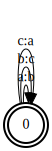

In [34]:
f=fst.Transducer()
f.add_arc(0,0,'a','b')
f.add_arc(0,0,'b','c')
f.add_arc(0,0,'c','a')
f[0].final=True
f

Now let's make another transducer, but this will have the same input and output symbols and they will form a sequence. 

Note that a transducer with identical input and output symbols is simply an automaton (FSA), or otherwise known as an *acceptor*.

We will use a helpful *linear_chain* method to generate such an acceptor:

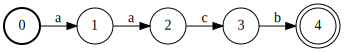

In [35]:
i=fst.linear_chain(['a','a','c','b'],syms=f.isyms)
i

### Composition

The most useful method used in a transducer is composition. This operation takes two transducers, e.g. one converting from symbol space A into B, and second converting from B into C and creates a third transducer that converts from A into C that is like a combination of the original ones.

We can use this method (denoted by the >> operator) to process the input chain transducer using our token converter above. The project_output method simply copies the output symbols to the input in order to discard the input symbols:

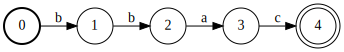

In [36]:
o=i>>f
o.project_output()
o

It pays off to think about this for a while until it's clear what is actually going on here. For more help, I recommend reading some of the docs at the [OpenFST](http://www.openfst.org/twiki/bin/view/FST/WebHome) website.

We can also process several sequences at once. Here we create a transducer that is a union of 3 sub-transducers. We will also expand our definition of the new symbols. We have to remove epsilon, because (apart from being uneccessary) jupyter notebook has issues with printing unicode characters in SVG:

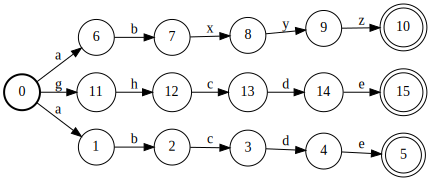

In [37]:
f=fst.Transducer()
f.add_arc(0,0,'a','b')
f.add_arc(0,0,'b','c')
f.add_arc(0,0,'c','a')
f.add_arc(0,0,'d','f')
f.add_arc(0,0,'e','g')
f.add_arc(0,0,'f','h')
f.add_arc(0,0,'g','e')
f.add_arc(0,0,'h','f')
f.add_arc(0,0,'x','x')
f.add_arc(0,0,'y','y')
f.add_arc(0,0,'z','z')
f[0].final=True

i1=fst.linear_chain(['a','b','c','d','e'],syms=f.isyms)
i2=fst.linear_chain(['a','b','x','y','z'],syms=f.isyms)
i3=fst.linear_chain(['g','h','c','d','e'],syms=f.isyms)
i=i1.union(i2)
i=i.union(i3)
i.remove_epsilon()
i

Now, this graph can be made more efficient by using determinization and minimization. Note that the graph below is equivalent to the one above, but has less states and transitions. This is especially useful with big graphs:

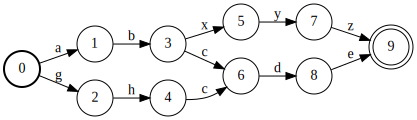

In [38]:
i=i.determinize()
i.minimize()
i

And we can still produce an output, like before:

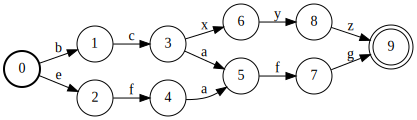

In [39]:
o=i>>f
o.project_output()
o

This method is also useful to combine a chain of operations into one complete transducer, for example to create a speech recognition pipeline as mentioned in the chapter about HMMs above. We can create a separate transducer for modeling phonemes, one for converting phonemes into words and another one for modeling sequences of words and combine all three into one large transducer converting context-indepentend phonemes into context-depndent words.

## HMM example using WFST

Let's reitrate our HMM example above using WFSTs. First lets convert the observation matrix into an input sequence:

In [40]:
def obs_mat(O,b,N,T):
    f=fst.StdAcceptor()
        
    for t in range(T):
        for j in range(N):
            f.add_arc(t,t+1,str(j),-np.log(b[j,O[t]]))
        
    f[T].final=True
    
    return f

obs_fsa=obs_mat(O,b,N,T)

A thing to note is that weights in FSTs are usually represented in a different way than in HMMs. We generally define weights in a specific semiring: in this case the [tropical semiring](https://en.wikipedia.org/wiki/Tropical_geometry). 

This semiring defines that the combination of two weigts is implemented using the sum. Probabilities are usually added togehter by multiplying them with each other. If we convert them into the log domain, the multiplication changes into a sum. Taking a logarithm of a value between 0 and 1 (i.e. probability) caonstraints the result to values between $-\inf$ to 0. The value of 0 is the best, and $-\inf$ is the worst. The tropical semiring works in the opposite direction, so we also have to take the negative of the logarithm to redefine values from 0 to $\inf$ and make the smaller values better than higher:

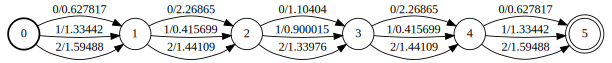

In [41]:
obs_fsa

This FSA simply chains several sequences in parallel. Each state represent a time step and the transitions in between are the individual observations. It's shape is what made it known as the *sausage*.

Now, we can also incorporate the priors and transitions in another FST that looks like this:

In [42]:
def trans_mat(pi,a,N):
    f=fst.StdAcceptor()
    
    for i in range(N):
        f.add_arc(0,i+1,str(i),-np.log(pi[i]))
    
    for i in range(N):
        for j in range(N):
            f.add_arc(i+1,j+1,str(j),-np.log(a[i,j]))
        
    for i in range(N):
        f[i+1].final=True
    
    return f

tr_fsa=trans_mat(pi,a,N)

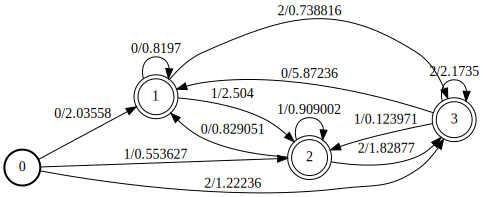

In [43]:
tr_fsa

Now lets combine the input sausage with the above transitions:

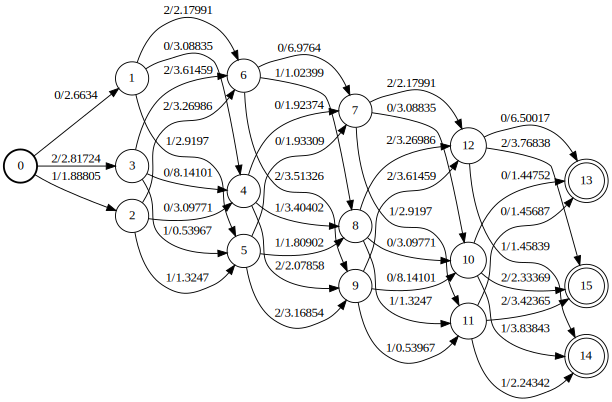

In [44]:
out_fsa=obs_fsa>>tr_fsa
out_fsa

What we get is a graph representing all the possible transitions among between all possible states with their corresponging weights. If we use the *shortest_path* method on this graph, we will get the same path as by using Viterbi:

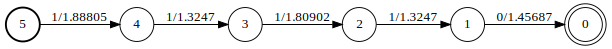

In [45]:
sh_p=out_fsa.shortest_path()
sh_p

In [46]:
shp_l=[]
for p in sh_p.paths():
    for s in p:
        shp_l.append(sh_p.osyms.find(s.olabel))
print shp_l

[u'1', u'1', u'1', u'1', u'0']


In [47]:
print viterbi(*hmm)

[1 1 1 1 0]
